# Functions

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline
# import logging
# logging.getLogger().setLevel(logging.CRITICAL)

In [30]:
from scipy.io import loadmat
exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'
# for Fc in [1, 4]:
dt = 0.01
sampling_rate = 20000

cmind = 0
Mean = 10
STD = 2
Mag_list = [0.2,0.6,1,1.3]
channelnumbers = [30, 32, 26, 15]

c1 = 0
Spike_list = [0]*len(Mag_list)
x_list = [0]*len(Mag_list)
# Spike_list = [0]*len(Mag_list)
for Mag in Mag_list:

    if Mag == 1:
        filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(STD)+'_11-Aug-2021_0'

    else:
        filename = 'diode_OU_tau=500ms_cutoff=1_coeff='+str(Mag)+'_11-Aug-2021_0'
    annots = loadmat(exp_folder+filename)
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    # x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
    x = x[::int(sampling_rate*dt)]
    x_list[c1] = x.astype(float)


    Spike_list[c1] = [0]*len(channelnumbers)
    c2=0
    for channelnumber in channelnumbers:
        Spike = np.squeeze( annots['Spikes'][0][channelnumber-1]-TimeStamps[0] )
        Spike = np.delete(Spike, np.where(Spike<=0))
        Spike_list[c1][c2] = Spike.copy()
        c2+=1
        # print(str(Mag)+'; '+str(len(Spike)/300))
    c1+=1

Spike2DList = np.array(Spike_list)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


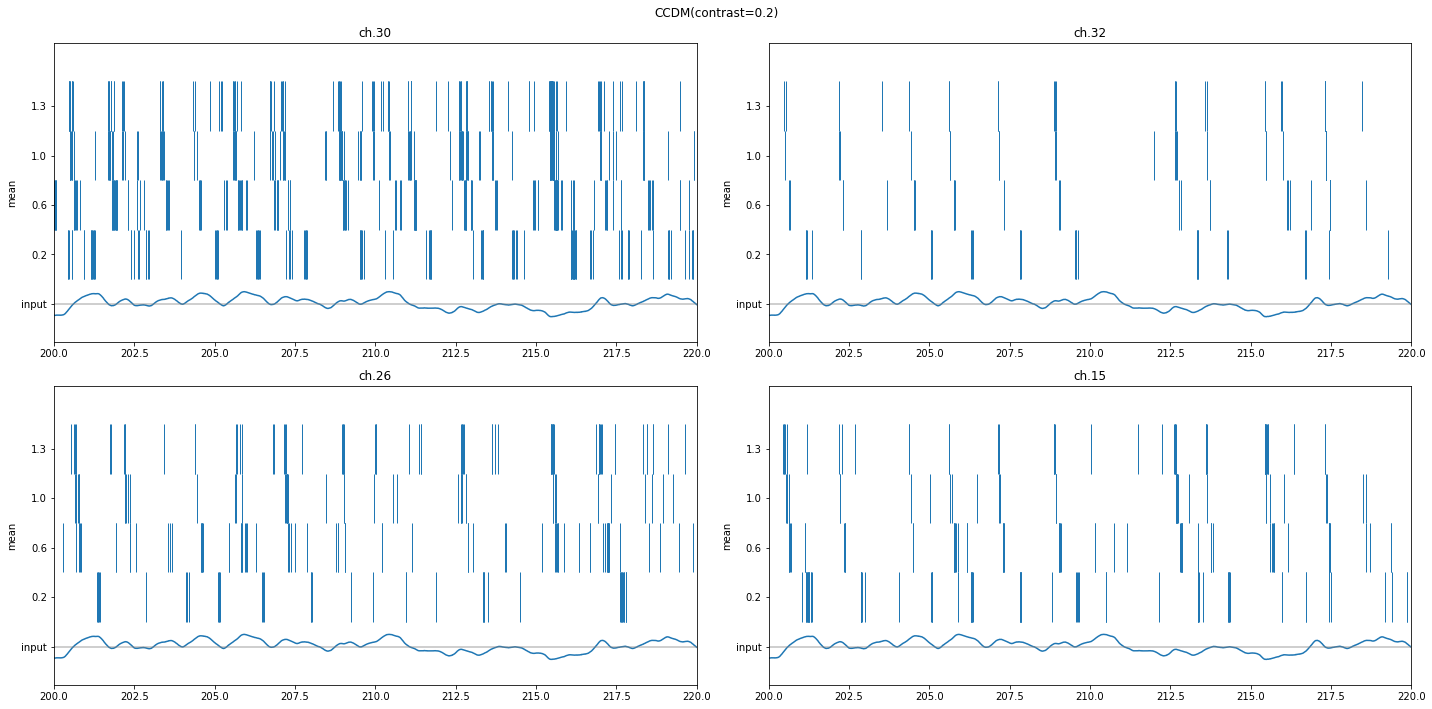

In [40]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle('CCDM(contrast=0.2)')
for channelnumber in channelnumbers:
    ax.flatten()[c2].plot(np.arange(len(x))*dt, (x-min(x))/(max(x)-min(x))-1.5)
    ax.flatten()[c2].axhline(-1, c='gray', alpha = 0.5)
    ax.flatten()[c2].eventplot(Spike2DList[:,c2], linewidths=1)
    ax.flatten()[c2].set_yticks(np.arange(-1,len(Mag_list)))
    ax.flatten()[c2].set_yticklabels(['input', '0.2', '0.6', '1.0', '1.3'])
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    ax.flatten()[c2].set_ylabel('mean')
    # plt.xlim(0,50)
    ax.flatten()[c2].set_xlim(200,220)
    
    c2+=1
fig.set_size_inches(20, 10)
fig.tight_layout()

In [4]:
def synchIndex(testSpike, refSpike, tolerance):
    numerator = 0 # numerator = number of spikes in testSpike which there is also a spike in refSpike in the range of tolerance around.
    denominator = 0 # denominator = number of spikes in testSpike
    for spike in testSpike:
        denominator+=1
        if np.sum((refSpike>=(spike-tolerance)) & (refSpike<=(spike+tolerance))) > 0:
            numerator+=1
    return numerator/denominator

In [5]:
# for toleranceMag in 10**np.arange(-2,2,0.5):
#     tolerance = dt*toleranceMag
#     plt.scatter(toleranceMag, synchIndex(Spike2DList[1,0], Spike2DList[2,0], tolerance), c = 'r')

# for toleranceMag in 10**np.arange(-2,2,0.5):
#     tolerance = dt*toleranceMag
#     plt.scatter(toleranceMag, synchIndex(Spike2DList[2,0], Spike2DList[1,0], tolerance), c = 'b')

# for toleranceMag in 10**np.arange(-2,2,0.5):
#     tolerance = dt*toleranceMag
#     plt.scatter(toleranceMag, synchIndex(Spike2DList[0,3], Spike2DList[3,3], tolerance), c = 'g')
# plt.xscale('log')

In [15]:
tolerance = 10*dt

synchMatrix = np.ones((len(Mag_list),len(Mag_list),len(channelnumbers)))
for ch in range(len(channelnumbers)):
    for i1 in range(len(Mag_list)):
        for i2 in range(len(Mag_list)):
            if i1==i2: continue
            synchMatrix[i1,i2,ch] = synchIndex(Spike2DList[i1,ch], Spike2DList[i2,ch], tolerance)

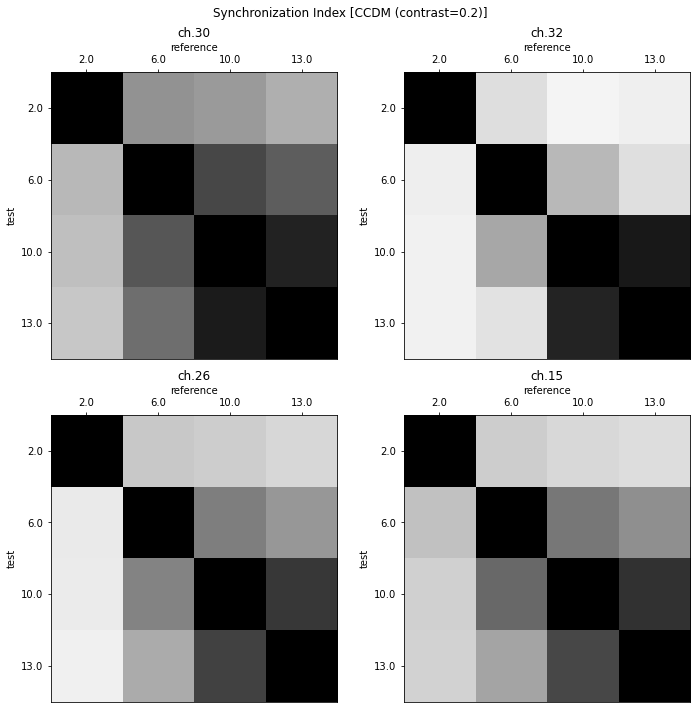

In [16]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle('Synchronization Index [CCDM (contrast=0.2)]')
for channelnumber in channelnumbers:
    ax.flatten()[c2].imshow(synchMatrix[:,:,c2], vmin = 0, vmax = 1, cmap = 'Greys')
    ax.flatten()[c2].set_yticks(np.arange(len(Mag_list)))
    ax.flatten()[c2].set_yticklabels(np.array(Mag_list)*Mean)
    ax.flatten()[c2].set_ylabel('test')
    ax.flatten()[c2].set_xticks(np.arange(len(Mag_list)))
    ax.flatten()[c2].set_xticklabels(np.array(Mag_list)*Mean)
    ax.flatten()[c2].set_xlabel('reference')
    ax.flatten()[c2].xaxis.tick_top()
    ax.flatten()[c2].xaxis.set_label_position('top')
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    # ax.flatten()[c2].set_ylabel('mean')
    c2+=1
fig.set_size_inches(10, 10)
fig.tight_layout()

In [17]:
synchMatrix[:,:,1]

array([[1.        , 0.21990741, 0.08796296, 0.13194444],
       [0.13432836, 1.        , 0.38992537, 0.21641791],
       [0.115727  , 0.44510386, 1.        , 0.91691395],
       [0.11594203, 0.20048309, 0.87681159, 1.        ]])